In [1]:
import torch
from torch import nn
import torch.optim as optim

from torchvision import transforms, datasets
from torchvision.utils import make_grid

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchstat import stat

from tqdm import tqdm, trange
import wandb
from torchvision.utils import save_image
import numpy as np
import matplotlib

matplotlib.style.use('ggplot')

## 定义生成器和辨别器

In [2]:
# generator
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            # nz will be the input to the first convolution
            nn.ConvTranspose2d(
                nz, 512, kernel_size=4, 
                stride=1, padding=0, bias=False),  # B, 512, 4, 4
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                512, 256, kernel_size=4, 
                stride=2, padding=1, bias=False),  # B, 256, 8, 8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                256, 128, kernel_size=4, 
                stride=2, padding=1, bias=False),  # B, 128, 16, 16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                128, 64, kernel_size=4, 
                stride=2, padding=1, bias=False),  # B, 64, 32, 32
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                64, 3, kernel_size=4, 
                stride=2, padding=1, bias=False),  # B, 3, 64, 64
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

In [3]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                3, 64, kernel_size=4, 
                stride=2, padding=1, bias=False),  # B, 64, 32, 32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                64, 128, kernel_size=4, 
                stride=2, padding=1, bias=False),  # B, 128, 16, 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                128, 256, kernel_size=4, 
                stride=2, padding=1, bias=False),  # B, 256, 8, 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                256, 512, kernel_size=4, 
                stride=2, padding=1, bias=False),  # B, 512, 4, 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                512, 1, kernel_size=4, 
                stride=1, padding=0, bias=False),  # B, 1, 1, 1
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

## utils

In [4]:
# set the computation device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
def label_real(size):
    """
    Fucntion to create real labels (ones)
    :param size: batch size
    :return real label vector
    """
    data = torch.ones(size, 1)
    return data.to(device)

def label_fake(size):
    """
    Fucntion to create fake labels (zeros)
    :param size: batch size
    :returns fake label vector
    """
    data = torch.zeros(size, 1)
    return data.to(device)

def create_noise(sample_size, nz):
    """
    Fucntion to create noise
    :param sample_size: fixed sample size or batch size
    :param nz: latent vector size
    :returns random noise vector
    """
    return torch.randn(sample_size, nz, 1, 1).to(device)

def save_generator_image(image, path):
    """
    Function to save torch image batches
    :param image: image tensor batch
    :param path: path name to save image
    """
    save_image(image, path, normalize=True)
    
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## 定义超参数

In [5]:
# learning parameters / configurations according to paper
image_size = 64 # we need to resize image to 64x64
batch_size = 128
nz = 100 # latent vector size
beta1 = 0.5 # beta1 value for Adam optimizer
lr = 0.0002 # learning rate according to paper
sample_size = 64 # fixed sample size
epochs = 200 # number of epoch to train
# set the computation device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

## 加载数据集

In [6]:
# image transforms
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), 
    (0.5, 0.5, 0.5)),
])
# prepare the data
train_data = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


## 初始化生成器、辨别器

In [7]:
# initialize models
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device) 
# initialize generator weights
generator.apply(weights_init)
# initialize discriminator weights
discriminator.apply(weights_init)
pass

## 定义优化器和损失函数

In [8]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
# loss function
criterion = nn.BCELoss()
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch

## 定义辨别器训练函数

In [9]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    # get the real label vector
    real_label = label_real(b_size)
    # get the fake label vector
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    # get the outputs by doing real data forward pass
    output_real = discriminator(data_real).view(-1, 1)
    loss_real = criterion(output_real, real_label)
    # get the outputs by doing fake data forward pass
    output_fake = discriminator(data_fake).view(-1, 1)
    loss_fake = criterion(output_fake, fake_label)
    # compute gradients of real loss 
    loss_real.backward()
    # compute gradients of fake loss
    loss_fake.backward()
    # update discriminator parameters
    optimizer.step()
    return loss_real + loss_fake

## 定义生成器训练函数

In [10]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    # get the real label vector
    real_label = label_real(b_size)
    optimizer.zero_grad()
    # output by doing a forward pass of the fake data through discriminator
    output = discriminator(data_fake).view(-1, 1)
    loss = criterion(output, real_label)
    # compute gradients of loss
    loss.backward()
    # update generator parameters
    optimizer.step()
    return loss 

## 训练

In [11]:
# create the noise vector
noise = create_noise(sample_size, nz)

In [12]:
generator.train()
discriminator.train()
pass

In [13]:
wandb.init(project="Gan", name="DCGAN", entity="ruizhuo_xu")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ruizhuo_xu. Use `wandb login --relogin` to force relogin


391it [01:13,  5.34it/s]                         


Epoch 1 of 100
Generator loss: 7.45828056, Discriminator loss: 0.47360790


  6%|▌         | 24/390 [00:04<01:08,  5.34it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:12,  5.38it/s]                         


Epoch 2 of 100
Generator loss: 4.02219963, Discriminator loss: 0.75296229


  6%|▌         | 23/390 [00:04<01:08,  5.38it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:12,  5.42it/s]                         


Epoch 3 of 100
Generator loss: 3.80518866, Discriminator loss: 0.60231143


  5%|▌         | 21/390 [00:03<01:07,  5.49it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.47it/s]                         


Epoch 4 of 100
Generator loss: 3.37014675, Discriminator loss: 0.66051209


  5%|▌         | 21/390 [00:03<01:06,  5.52it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 5 of 100
Generator loss: 3.01004815, Discriminator loss: 0.71475965


  4%|▎         | 14/390 [00:02<01:08,  5.49it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 6 of 100
Generator loss: 2.81503701, Discriminator loss: 0.74951339


  5%|▌         | 21/390 [00:03<01:07,  5.47it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 7 of 100
Generator loss: 2.65225649, Discriminator loss: 0.77673125


  5%|▌         | 20/390 [00:03<01:07,  5.49it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 8 of 100
Generator loss: 2.52699161, Discriminator loss: 0.81242818


  3%|▎         | 10/390 [00:01<01:09,  5.50it/s]wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 9 of 100
Generator loss: 2.51430988, Discriminator loss: 0.79310471


  6%|▌         | 22/390 [00:04<01:07,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 10 of 100
Generator loss: 2.47629905, Discriminator loss: 0.82817537


  6%|▌         | 22/390 [00:04<01:07,  5.47it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 11 of 100
Generator loss: 2.66570354, Discriminator loss: 0.74231982


  6%|▌         | 22/390 [00:03<01:07,  5.49it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 12 of 100
Generator loss: 2.92196584, Discriminator loss: 0.70997179


  3%|▎         | 10/390 [00:01<01:09,  5.50it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 13 of 100
Generator loss: 2.76604486, Discriminator loss: 0.75852740


  6%|▌         | 22/390 [00:04<01:07,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 14 of 100
Generator loss: 2.52898765, Discriminator loss: 0.79605937


391it [01:11,  5.48it/s]                         


Epoch 15 of 100
Generator loss: 3.17176032, Discriminator loss: 0.59560215


 50%|█████     | 195/390 [00:35<00:35,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 16 of 100
Generator loss: 3.16646194, Discriminator loss: 0.62921357


  4%|▍         | 16/390 [00:02<01:08,  5.46it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 17 of 100
Generator loss: 2.74290538, Discriminator loss: 0.80354273


  6%|▌         | 24/390 [00:04<01:06,  5.47it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 18 of 100
Generator loss: 2.97490430, Discriminator loss: 0.66768885


  5%|▌         | 21/390 [00:03<01:07,  5.50it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 19 of 100
Generator loss: 2.60776973, Discriminator loss: 0.79553473


  6%|▌         | 23/390 [00:04<01:07,  5.45it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 20 of 100
Generator loss: 3.27479672, Discriminator loss: 0.57295215


  3%|▎         | 12/390 [00:02<01:09,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 21 of 100
Generator loss: 3.56539440, Discriminator loss: 0.58760166


  6%|▌         | 22/390 [00:04<01:07,  5.46it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 22 of 100
Generator loss: 2.85381818, Discriminator loss: 0.72473711


  5%|▌         | 21/390 [00:03<01:07,  5.45it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 23 of 100
Generator loss: 2.32585216, Discriminator loss: 0.83268660


  6%|▌         | 22/390 [00:03<01:07,  5.49it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 24 of 100
Generator loss: 3.28927135, Discriminator loss: 0.56963676


  3%|▎         | 10/390 [00:01<01:09,  5.47it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 25 of 100
Generator loss: 6.44493723, Discriminator loss: 0.01188779


  5%|▌         | 21/390 [00:03<01:07,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 26 of 100
Generator loss: 9.81646919, Discriminator loss: 0.00298075


  5%|▌         | 21/390 [00:03<01:07,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 27 of 100
Generator loss: 36.19839478, Discriminator loss: 0.00003657


  6%|▌         | 22/390 [00:03<01:07,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 28 of 100
Generator loss: 10.29949474, Discriminator loss: 0.32405505


  7%|▋         | 27/390 [00:04<01:06,  5.45it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 29 of 100
Generator loss: 5.07456684, Discriminator loss: 0.33373094


  3%|▎         | 11/390 [00:01<01:09,  5.45it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 30 of 100
Generator loss: 4.42169714, Discriminator loss: 0.42608735


  3%|▎         | 10/390 [00:01<01:08,  5.54it/s]wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 31 of 100
Generator loss: 4.79573059, Discriminator loss: 0.35785317


  6%|▌         | 23/390 [00:04<01:07,  5.47it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 32 of 100
Generator loss: 3.43703055, Discriminator loss: 0.53043753


391it [01:11,  5.48it/s]                         


Epoch 33 of 100
Generator loss: 3.10392451, Discriminator loss: 0.59949195


  3%|▎         | 10/390 [00:01<01:08,  5.53it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 34 of 100
Generator loss: 3.34597611, Discriminator loss: 0.56848323


  4%|▍         | 15/390 [00:02<01:08,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 35 of 100
Generator loss: 3.02528930, Discriminator loss: 0.56178910


  6%|▌         | 24/390 [00:04<01:06,  5.49it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 36 of 100
Generator loss: 6.24909639, Discriminator loss: 0.01053905


  3%|▎         | 10/390 [00:01<01:08,  5.52it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 37 of 100
Generator loss: 7.50743294, Discriminator loss: 0.00294559


  6%|▌         | 22/390 [00:03<01:06,  5.55it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 38 of 100
Generator loss: 10.06822968, Discriminator loss: 0.00205073


  5%|▌         | 21/390 [00:03<01:07,  5.47it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 39 of 100
Generator loss: 9.39214325, Discriminator loss: 0.22320865


  6%|▌         | 24/390 [00:04<01:06,  5.47it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 40 of 100
Generator loss: 6.17925882, Discriminator loss: 0.22265479


 12%|█▏        | 46/390 [00:08<01:03,  5.45it/s]wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 41 of 100
Generator loss: 5.59824181, Discriminator loss: 0.23347664


  5%|▌         | 21/390 [00:03<01:07,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 42 of 100
Generator loss: 5.12131882, Discriminator loss: 0.24492836


  6%|▌         | 22/390 [00:03<01:07,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 43 of 100
Generator loss: 4.77197123, Discriminator loss: 0.32858896


  3%|▎         | 10/390 [00:01<01:08,  5.51it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 44 of 100
Generator loss: 5.46759319, Discriminator loss: 0.28676251


  6%|▌         | 24/390 [00:04<01:06,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 45 of 100
Generator loss: 4.22984171, Discriminator loss: 0.28647029


  6%|▌         | 23/390 [00:04<01:06,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 46 of 100
Generator loss: 4.42332697, Discriminator loss: 0.33859429


  4%|▎         | 14/390 [00:02<01:08,  5.49it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 47 of 100
Generator loss: 3.95581007, Discriminator loss: 0.32785505


  9%|▉         | 35/390 [00:06<01:04,  5.47it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 48 of 100
Generator loss: 3.91676736, Discriminator loss: 0.44592068


  5%|▍         | 18/390 [00:03<01:08,  5.47it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 49 of 100
Generator loss: 3.92642760, Discriminator loss: 0.32722631


  3%|▎         | 10/390 [00:01<01:08,  5.52it/s]wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 50 of 100
Generator loss: 3.88638425, Discriminator loss: 0.40661094


  2%|▏         | 9/390 [00:01<01:09,  5.49it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 51 of 100
Generator loss: 4.40419817, Discriminator loss: 0.33900547


391it [01:11,  5.48it/s]                         


Epoch 52 of 100
Generator loss: 3.69660163, Discriminator loss: 0.49548337


  5%|▌         | 21/390 [00:03<01:07,  5.49it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 53 of 100
Generator loss: 3.69496799, Discriminator loss: 0.42936751


  6%|▌         | 23/390 [00:04<01:06,  5.50it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 54 of 100
Generator loss: 3.47730994, Discriminator loss: 0.45708707


  3%|▎         | 11/390 [00:01<01:09,  5.46it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 55 of 100
Generator loss: 4.18110561, Discriminator loss: 0.37580383


  3%|▎         | 10/390 [00:01<01:09,  5.50it/s]wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 56 of 100
Generator loss: 3.80329657, Discriminator loss: 0.39795956


  4%|▍         | 16/390 [00:02<01:08,  5.47it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 57 of 100
Generator loss: 3.40458107, Discriminator loss: 0.51427960


  3%|▎         | 11/390 [00:01<01:09,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 58 of 100
Generator loss: 4.11950397, Discriminator loss: 0.34933355


  3%|▎         | 11/390 [00:01<01:09,  5.45it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 59 of 100
Generator loss: 3.83930874, Discriminator loss: 0.48617163


 24%|██▍       | 95/390 [00:17<00:54,  5.45it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 60 of 100
Generator loss: 3.94551229, Discriminator loss: 0.38034537


  8%|▊         | 33/390 [00:06<01:04,  5.50it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 61 of 100
Generator loss: 3.40077353, Discriminator loss: 0.51115626


  3%|▎         | 11/390 [00:01<01:08,  5.53it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 62 of 100
Generator loss: 3.44694591, Discriminator loss: 0.54954720


391it [01:11,  5.48it/s]                         


Epoch 63 of 100
Generator loss: 4.17127991, Discriminator loss: 0.34259430


  4%|▍         | 17/390 [00:03<01:07,  5.49it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 64 of 100
Generator loss: 3.64553642, Discriminator loss: 0.52254355


391it [01:11,  5.48it/s]                         


Epoch 65 of 100
Generator loss: 3.60728240, Discriminator loss: 0.43799415


  5%|▌         | 21/390 [00:03<01:07,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 66 of 100
Generator loss: 4.50951576, Discriminator loss: 0.35962012


  4%|▎         | 14/390 [00:02<01:08,  5.51it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 67 of 100
Generator loss: 3.55597353, Discriminator loss: 0.43032169


  3%|▎         | 10/390 [00:01<01:09,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 68 of 100
Generator loss: 3.61078072, Discriminator loss: 0.47644475


  3%|▎         | 12/390 [00:02<01:09,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 69 of 100
Generator loss: 5.18898153, Discriminator loss: 0.14822917


  1%|▏         | 5/390 [00:00<01:09,  5.54it/s]wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 70 of 100
Generator loss: 4.62501621, Discriminator loss: 0.39286992


  3%|▎         | 10/390 [00:01<01:09,  5.49it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 71 of 100
Generator loss: 3.83316445, Discriminator loss: 0.43172976


  6%|▌         | 23/390 [00:04<01:07,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 72 of 100
Generator loss: 3.95521975, Discriminator loss: 0.41817480


  4%|▎         | 14/390 [00:02<01:08,  5.47it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 73 of 100
Generator loss: 5.50175858, Discriminator loss: 0.22357364


  3%|▎         | 10/390 [00:01<01:09,  5.49it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 74 of 100
Generator loss: 3.54394197, Discriminator loss: 0.50945318


391it [01:11,  5.48it/s]                         


Epoch 75 of 100
Generator loss: 3.29136014, Discriminator loss: 0.42109489


391it [01:11,  5.48it/s]                         


Epoch 76 of 100
Generator loss: 4.57742262, Discriminator loss: 0.30787602


391it [01:11,  5.48it/s]                         


Epoch 77 of 100
Generator loss: 3.37412596, Discriminator loss: 0.51876253


 22%|██▏       | 84/390 [00:15<00:56,  5.46it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 78 of 100
Generator loss: 3.92597532, Discriminator loss: 0.35201147


  3%|▎         | 11/390 [00:01<01:09,  5.45it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 79 of 100
Generator loss: 4.39771223, Discriminator loss: 0.31511813


391it [01:11,  5.48it/s]                         


Epoch 80 of 100
Generator loss: 3.64267063, Discriminator loss: 0.53466523


391it [01:11,  5.48it/s]                         


Epoch 81 of 100
Generator loss: 4.06829023, Discriminator loss: 0.38234842


391it [01:11,  5.48it/s]                         


Epoch 82 of 100
Generator loss: 5.09508562, Discriminator loss: 0.25314346


  6%|▌         | 23/390 [00:04<01:06,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 83 of 100
Generator loss: 3.84747410, Discriminator loss: 0.44158721


391it [01:11,  5.48it/s]                         


Epoch 84 of 100
Generator loss: 4.18997049, Discriminator loss: 0.32920024


  3%|▎         | 11/390 [00:01<01:08,  5.51it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 85 of 100
Generator loss: 3.96693945, Discriminator loss: 0.42145893


391it [01:11,  5.48it/s]                         


Epoch 86 of 100
Generator loss: 3.81679606, Discriminator loss: 0.41939387


391it [01:11,  5.48it/s]                         


Epoch 87 of 100
Generator loss: 3.73594761, Discriminator loss: 0.41244075


391it [01:11,  5.48it/s]                         


Epoch 88 of 100
Generator loss: 3.23244667, Discriminator loss: 0.46287984


391it [01:11,  5.48it/s]                         


Epoch 89 of 100
Generator loss: 3.68947291, Discriminator loss: 0.47942877


391it [01:11,  5.48it/s]                         


Epoch 90 of 100
Generator loss: 4.18500280, Discriminator loss: 0.31706464


391it [01:11,  5.48it/s]                         


Epoch 91 of 100
Generator loss: 3.35255146, Discriminator loss: 0.49260810


391it [01:11,  5.48it/s]                         


Epoch 92 of 100
Generator loss: 3.82553291, Discriminator loss: 0.40269804


391it [01:11,  5.48it/s]                         


Epoch 93 of 100
Generator loss: 6.31676340, Discriminator loss: 0.00809101


391it [01:11,  5.48it/s]                         


Epoch 94 of 100
Generator loss: 6.97203493, Discriminator loss: 0.00485094


 17%|█▋        | 67/390 [00:12<00:59,  5.46it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 95 of 100
Generator loss: 7.92112732, Discriminator loss: 0.00159676


  2%|▏         | 9/390 [00:01<01:09,  5.51it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 96 of 100
Generator loss: 12.75585461, Discriminator loss: 0.00197017


  4%|▎         | 14/390 [00:02<01:08,  5.49it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 97 of 100
Generator loss: 10.87322044, Discriminator loss: 0.24537395


391it [01:11,  5.48it/s]                         


Epoch 98 of 100
Generator loss: 7.01301956, Discriminator loss: 0.34223095


  3%|▎         | 12/390 [00:02<01:09,  5.48it/s]wandb: Network error (TransientError), entering retry loop.
391it [01:11,  5.48it/s]                         


Epoch 99 of 100
Generator loss: 7.75944662, Discriminator loss: 0.11434238


391it [01:11,  5.48it/s]                         


Epoch 100 of 100
Generator loss: 5.82855606, Discriminator loss: 0.12916584
DONE TRAINING


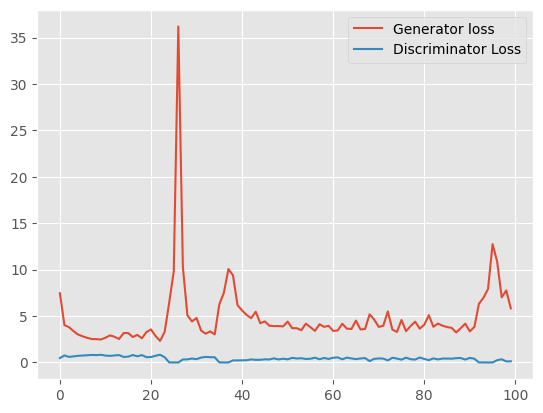

wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.


In [14]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # forward pass through generator to create fake data
        data_fake = generator(create_noise(b_size, nz)).detach()
        data_real = image
        loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        loss_g += train_generator(optim_g, data_fake)
    # final forward pass through generator to create fake data...
    # ...after training for current epoch
    generated_img = generator(noise).cpu().detach()
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"./outputs/gen_img{epoch}.png")
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    wandb.log(
        {
            "D_loss_epoch": epoch_loss_d,
            "G_loss_epoch": epoch_loss_g,
            "generated_img": wandb.Image(make_grid(generated_img, nrow=8, normalize=True)),
            "epoch": epoch+1

        }
    )
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")
print('DONE TRAINING')
# save the model weights to disk
torch.save(generator.state_dict(), './outputs/generator.pth')
# plot and save the generator and discriminator loss
plt.figure()
losses_d = [x.item() for x in losses_d]
losses_g = [x.item() for x in losses_g]
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('./outputs/loss.png')
plt.show()

In [14]:
print('DONE TRAINING')
# save the model weights to disk
torch.save(generator.state_dict(), './outputs/generator.pth')

DONE TRAINING


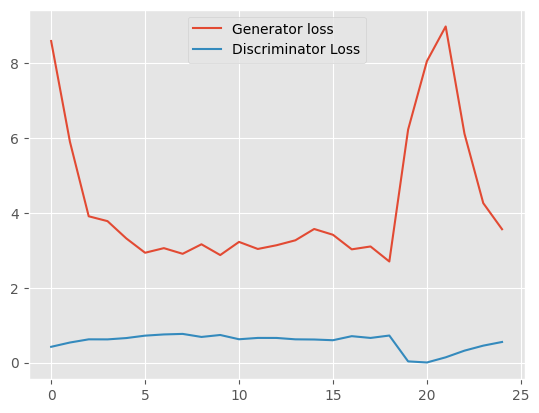

In [17]:
# plot and save the generator and discriminator loss
plt.figure()
losses_d = [x.item() for x in losses_d]
losses_g = [x.item() for x in losses_g]
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('./outputs/loss.png')
plt.show()